# Echograms preparation

Here we try to retrieve data from the "Echointegration.mat" obtained during the ABRACOS1 campaign, then turning into a `torch.Tensor()` before making various crops in order to build a `Dataset`.

## 0. Getting setup and retrieving data

In [46]:
# Importing necessary modules
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math

try:
    import h5py
except:
    print("Couldn't find h5py extension, installing it.")
    !pip install h5py
    import h5py

import torch

In [47]:
# Setting up working directory and retrieving data

os.chdir("C:\\Users\\Gaspard\\Desktop\\Etudes\\L'X\\Stage 3A - MARBEC\\Data\\ABRACOS1\\EI002_High_resolution")
print(f"Current working directory: {os.getcwd()}")

# Retrieving .mat data with h5py.File (scipy.io.loadmat doesn't work on v7.3 files)
EI = h5py.File('Echointegration.mat','r')
EI

Current working directory: C:\Users\Gaspard\Desktop\Etudes\L'X\Stage 3A - MARBEC\Data\ABRACOS1\EI002_High_resolution


<HDF5 file "Echointegration.mat" (mode r)>

In [48]:
Sv_surface_array = np.array(EI.get("Sv_surface"))
Sv_surface_tensor = torch.from_numpy(Sv_surface_array)
print(f"Sv_surface shape: {Sv_surface_tensor.shape} -> [color_channels (4), width, height] (CWH)")

Sv_surface shape: torch.Size([4, 415019, 745]) -> [color_channels (4), width, height] (CWH)


In [49]:
# Reshaping to CHW (torchvision's standard format)
Sv_surface_tensor = Sv_surface_tensor.permute(0, 2, 1)
print(f"New shape: {Sv_surface_tensor.shape} -> CHW")

New shape: torch.Size([4, 745, 415019]) -> CHW


## 1. Visualizing part of the data

In order to visualize the data, we will have to keep only 3 frequences, so we will discard the 4th one (200kHz).

In [50]:
HEIGHT = 745
WIDTH = 500

Sv_image = Sv_surface_tensor[:3, :HEIGHT, :WIDTH]
Sv_image = np.array(Sv_image.permute(1, 2, 0))
print(f"Image shape: {Sv_image.shape} -> HWC")

Image shape: (745, 500, 3) -> HWC


In [51]:
Sv_image[0, 0, :]

array([-150., -150., -150.], dtype=float32)

In [52]:
Sv_image.min(), Sv_image.max()

(nan, nan)

We need to project `Sv_image` values (logarithmic echogram values) into RGB values ([0, 255] for int, [0, 1] for float). A possibility is to simply offset the intensities.

We will then replace the `NaN` values by 0.

In [53]:
Sv_image += 150
Sv_image.min(), Sv_image.max()

(nan, nan)

In [54]:
# Need to replace NaN by 0 for better visualization

for h in range(HEIGHT):
     for w in range(WIDTH):
            for c in range(3):
                if math.isnan(Sv_image[h, w, c]):
                    Sv_image[h, w, c] = 0
Sv_image.min(), Sv_image.max()

(0.0, 98.139984)

In [55]:
Sv_image = Sv_image.astype(int)

In [56]:
Sv_image.min(), Sv_image.max()

(0, 98)

Text(0.5, 1.0, 'Top left corner of the echogram, size = 500x745')

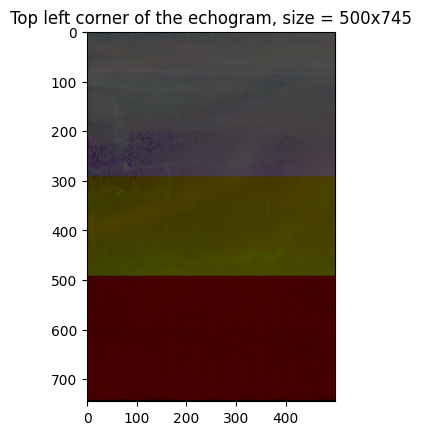

In [57]:
plt.figure()
plt.imshow(Sv_image)

plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")

We seem to have a contrast issue. Let's see what can be done about it.

Text(0.5, 1.0, 'Top left corner of the echogram, size = 500x745')

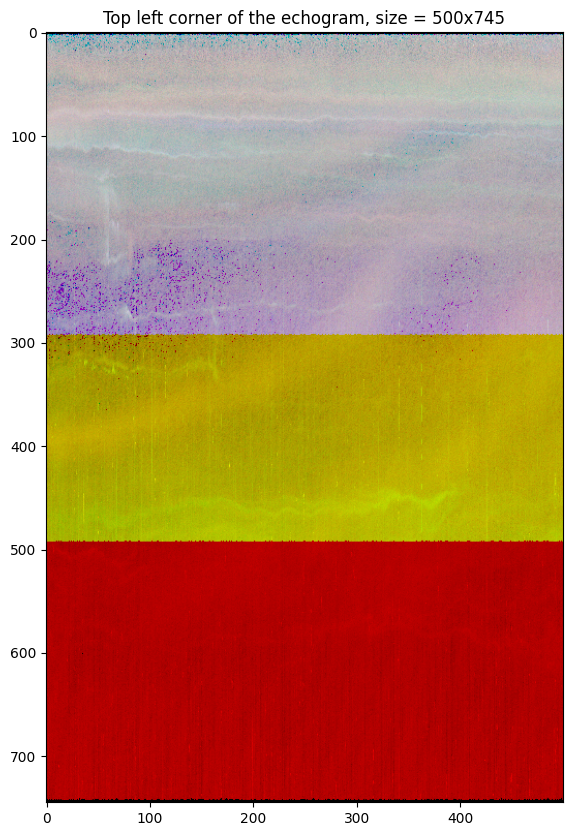

In [58]:
# Increasing contrast

# Get brightness range - i.e. darkest and lightest pixels
min=np.min(Sv_image)        # result=144
max=np.max(Sv_image)        # result=216

# Make a LUT (Look-Up Table) to translate image values
LUT=np.zeros(256,dtype=np.uint8)
LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)

Sv_image_contrasted = LUT[Sv_image]
plt.figure(figsize=(10, 10))
plt.imshow(Sv_image_contrasted)

plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")

## 2. Preprocessing inspired by Matecho

In [59]:
# Defining thresholding function

def ApplyThresholds(x:torch.Tensor(), low, high=None):
    """Applies a threshold on a CHW tensor by limiting values to a minimum (low) and a maximum (high). 
    Also assigns NaN values to low. Operation are done in place.
    
    Args:
        x (torch.Tensor()): a CHW image format tensor.
        low (int)(optional): the minimum value to which any value below will be assigned. Defaults to None.
        high (int)(optional): the maximum value to which any value above will be assigned. Defaults to None.
    """
    for c in range(len(x[:, 0, 0])):
        for h in range(len(x[0, :, 0])):
             for w in range(len(x[0, 0, :])):
                    if math.isnan(x[c, h, w]) or x[c, h, w] < low:
                        x[c, h, w] = low
                    elif x[c, h, w] > high:
                        x[c, h, w] = high

In [60]:
# Applying thresholds on the data

LOW, HIGH = -80., -50.
sample_Sv_image = Sv_surface_tensor[:3, :HEIGHT, :WIDTH]

print(sample_Sv_image[:, 0, 0])
print(len(sample_Sv_image[0, :, 0]))
print(len(sample_Sv_image[0, 0, :]))

ApplyThresholds(sample_Sv_image, LOW, HIGH)

tensor([-150., -150., -150.])
745
500


In [61]:
# Visualizing function

def plot_echogram_with_contrast(x):
    Sv_image = np.array(x.permute(1, 2, 0)).astype(int)
    # Get brightness range - i.e. darkest and lightest pixels
    min=np.min(Sv_image)
    max=np.max(Sv_image) 

    # Make a LUT (Look-Up Table) to translate image values
    LUT=np.zeros(256,dtype=np.uint8)
    LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)

    Sv_image_contrasted = LUT[Sv_image]
    plt.figure(figsize=(10, 10))
    plt.imshow(Sv_image_contrasted)

    plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")

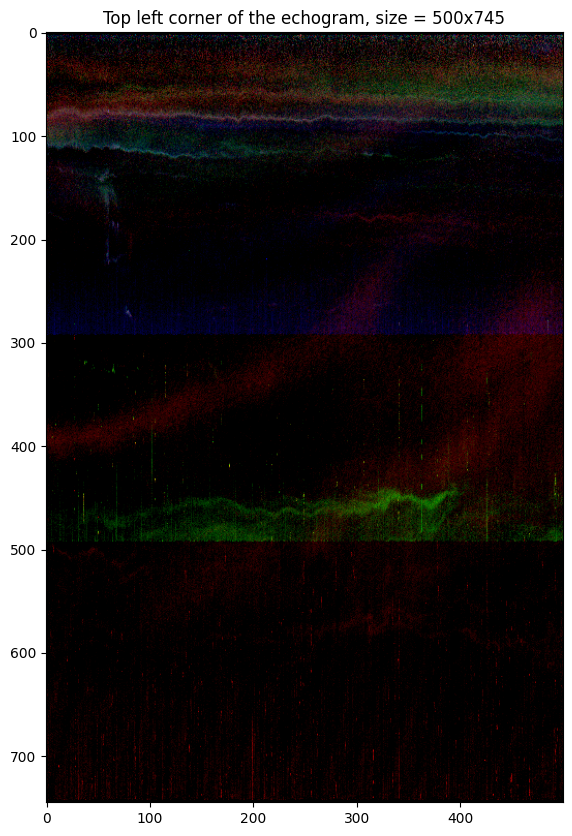

In [62]:
plot_echogram_with_contrast(sample_Sv_image)

This corresponds almost exactly to the Matecho output, except here we have the complete signal. We can see how the 70kHz and 120kHz frequencies are croped at 500m and 300m respectively.

In [63]:
EI.close()